In [1]:
# Observe gradient norm during training

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

/home/asifahm/.conda/envs/ece4420/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/asifahm/.conda/envs/ece4420/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [5]:
# Hyperparameters
input_size = 784  # MNIST image size (28x28) flattened
output_size = 10  # Number of output classes for MNIST (digits 0-9)
num_epochs = 50
batch_size = 64
learning_rate = 0.001

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Initialize model
model = Model().to(device)

In [9]:
print(model.parameters)
# total_params = sum(p.numel() for p in model.parameters())
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)>
39760


In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Store gradient norms and losses
grad_norms = []
train_losses = []

# Training loop
for epoch in range(num_epochs):
     model.train()
     for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Calculate gradient norm
        grad_all = 0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        grad_norms.append(grad_norm)

        # Update parameters
        optimizer.step()

        # Record loss
        train_losses.append(loss.item())

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Grad Norm: {grad_norm:.4f}')


Epoch [1/50], Step [100/938], Loss: 0.5729, Grad Norm: 1.1074
Epoch [1/50], Step [200/938], Loss: 0.4649, Grad Norm: 1.0854
Epoch [1/50], Step [300/938], Loss: 0.4196, Grad Norm: 0.9948
Epoch [1/50], Step [400/938], Loss: 0.4268, Grad Norm: 0.9908
Epoch [1/50], Step [500/938], Loss: 0.1851, Grad Norm: 0.4801
Epoch [1/50], Step [600/938], Loss: 0.1527, Grad Norm: 0.6362
Epoch [1/50], Step [700/938], Loss: 0.2743, Grad Norm: 0.5416
Epoch [1/50], Step [800/938], Loss: 0.1722, Grad Norm: 1.1375
Epoch [1/50], Step [900/938], Loss: 0.3123, Grad Norm: 0.9394
Epoch [2/50], Step [100/938], Loss: 0.4278, Grad Norm: 0.7359
Epoch [2/50], Step [200/938], Loss: 0.2680, Grad Norm: 1.3419
Epoch [2/50], Step [300/938], Loss: 0.1139, Grad Norm: 0.5031
Epoch [2/50], Step [400/938], Loss: 0.2520, Grad Norm: 1.1890
Epoch [2/50], Step [500/938], Loss: 0.2793, Grad Norm: 0.7716
Epoch [2/50], Step [600/938], Loss: 0.0633, Grad Norm: 0.2940
Epoch [2/50], Step [700/938], Loss: 0.2722, Grad Norm: 0.9162
Epoch [2

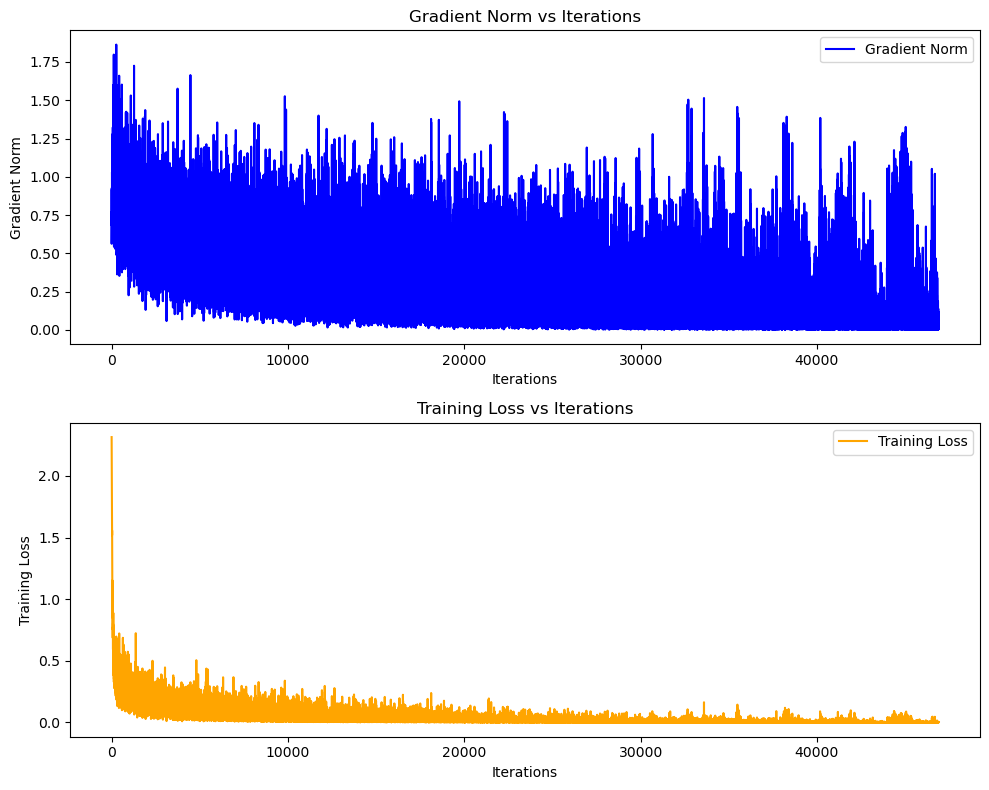

In [12]:
# Plotting gradient norm and training loss vs iterations
plt.figure(figsize=(10,8))

# First subplot: Gradient Norm
plt.subplot(2, 1, 1)
plt.plot(grad_norms, label='Gradient Norm', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm vs Iterations')
plt.legend()

# Second subplot: Training Loss
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()


plt.tight_layout()
plt.show()

Previous

In [13]:
# Function to compute the gradient norm
def compute_gradient_norm(model):
    total_norm = 0
    for param in model.parameters():
        param_norm = param.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

# Train the model and record gradient norm
gradient_norms = []

def train_and_record_gradient_norm(model, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Record gradient norm
            grad_norm = compute_gradient_norm(model)
            gradient_norms.append(grad_norm)

            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Gradient Norm: {grad_norm:.4f}')

# Reinitialize the model and optimizer
model = SimpleModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and record gradient norms
train_and_record_gradient_norm(model, optimizer, num_epochs)

# Plot gradient norm and training loss
plt.figure()
plt.plot(gradient_norms, label='Gradient Norm')
plt.title('Gradient Norm over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

plt.figure()
plt.plot(training_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'SimpleModel' is not defined